# Triple Junction Solar Cells

Triple junction solar cells are a type of multi-junction PV device that can exceed the Shockley-Queisser (detailed balance) limit.
It is designed to maximize efficiency by capturing and converting a broader spectrum of sunlight into electricity.

The three layers consist of the following:
1. Top Layer (GaInP - Gallium Indium Phosphide):
GaInP has a high bandgap (~1.85 eV) and absorbs high-energy photons (primarily in the blue and green regions of the spectrum).
2. Middle Layer (GaAs - Gallium Arsenide):
GaAs has a medium bandgap (~1.42 eV) and absorbs photons in the red and near-infrared region.
3. Bottom Layer (Ge - Germanium):
Ge has a low bandgap (~0.67 eV) and absorbs photons in the infrared region.

First of all, we import required packages.

In [1]:
import jax.numpy as jnp
import numpy as onp
import matplotlib.pyplot as plt

import jaxlayerlumos as jll
import jaxlayerlumos.utils_units as jll_utils_units
import jaxlayerlumos.utils_materials as jll_utils_materials
import jaxlayerlumos.utils_spectra as jll_utils_spectra
import jaxlayerlumos.utils_position as jll_utils_position
import jaxlayerlumos.utils_light_sources as jll_utils_light_sources

Here we plot the absorption as a function of photon energy for each of the three materials. The different spectral utilization of each layer can be observed.

In [2]:
wavelengths = jnp.linspace(280, 2000, 1000) * jll_utils_units.get_nano()
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)

materials = onp.array(["Air", "GaInP", "GaAs", "Ge"])
thicknesses = jnp.array([0, 1.0, 3.0, 0]) * jll_utils_units.get_micro()

n_k = jll_utils_materials.get_n_k(materials, frequencies)
inc_angle = 0

R_TE, T_TE, R_TM, T_TM, results_coeffs = jll.stackrt(
    n_k, thicknesses, frequencies, inc_angle, return_coeffs=True
)

A_TE = 1 - R_TE

# this returns the absorption at each specific thickness
results_coeffs = jll_utils_position.calc_absorption_in_each_layer(
    thicknesses, results_coeffs
)

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(
/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


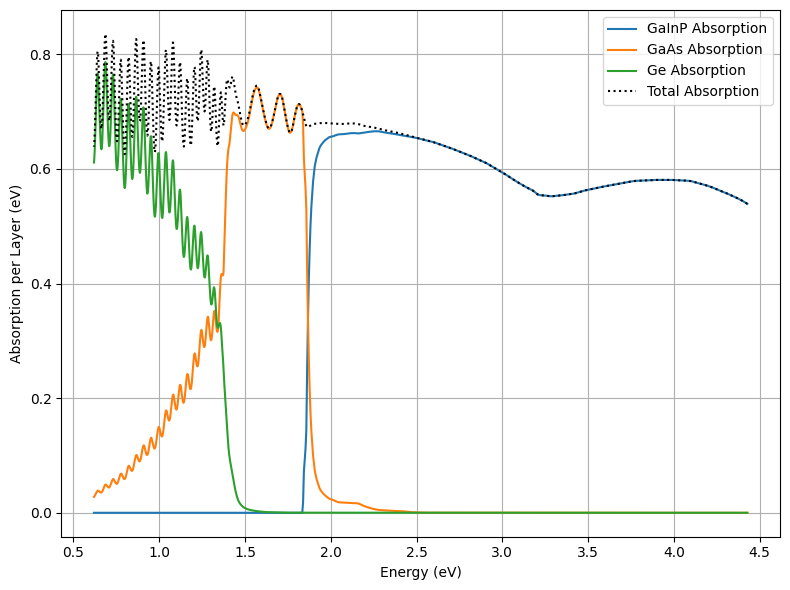

In [3]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

for i in range(1, 4):
    ax.plot(energy, results_coeffs["absorption_layer_TE"][i, :], label=f'{materials[i]} Absorption')

ax.plot(energy, A_TE.flatten(), 'k:', label='Total Absorption')

ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Absorption per Layer (eV)")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

We additionally want to see the absorption plotted as a function of position. In this case, we plot the solar absorption, which is defined as the spatially resolved absorption of incident solar radiation within each layer of the solar cell.



In [4]:
wavelengths_solar = jnp.linspace(280, 4000, 2000) * jll_utils_units.get_nano()
wavelengths_solar_in_nm = jll_utils_units.convert_m_to_nm(wavelengths_solar)
irradiance_solar = jll_utils_light_sources.get_irradiance('AM1p5G', wavelengths_solar)

photon_flux_solar = (irradiance_solar * wavelengths_solar) / (jll_utils_units.get_planck_constant() * jll_utils_units.get_light_speed())
total_photons_solar = onp.trapezoid(photon_flux_solar, wavelengths_solar_in_nm)

wavelengths = jnp.linspace(280, 2000, 1000) * jll_utils_units.get_nano()
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
energy = jll_utils_spectra.convert_wavelengths_to_energy(wavelengths)
irradiance = jll_utils_light_sources.get_irradiance('AM1p5G', wavelengths)
inc_angle = 0

photon_flux = (irradiance * wavelengths) / (jll_utils_units.get_planck_constant() * jll_utils_units.get_light_speed())
wavelengths_in_nm = jll_utils_units.convert_m_to_nm(wavelengths)

R_TE, T_TE, R_TM, T_TM, results_coeffs = jll.stackrt(
    n_k, thicknesses, frequencies, inc_angle, return_coeffs=True
)

position = onp.linspace(0, sum(thicknesses) * 1.5, 1000)
layer, position_in_layer = jll_utils_position.calc_position_in_structure(
    thicknesses, position
)

results_coeffs = jll_utils_position.calc_position_data(
    layer, position_in_layer, results_coeffs
)

absorption_location = onp.trapezoid(
    results_coeffs['absorb_TE'][0] * photon_flux[:, onp.newaxis],
    wavelengths_in_nm,
    axis=0
) / total_photons_solar * jll_utils_units.get_micro()

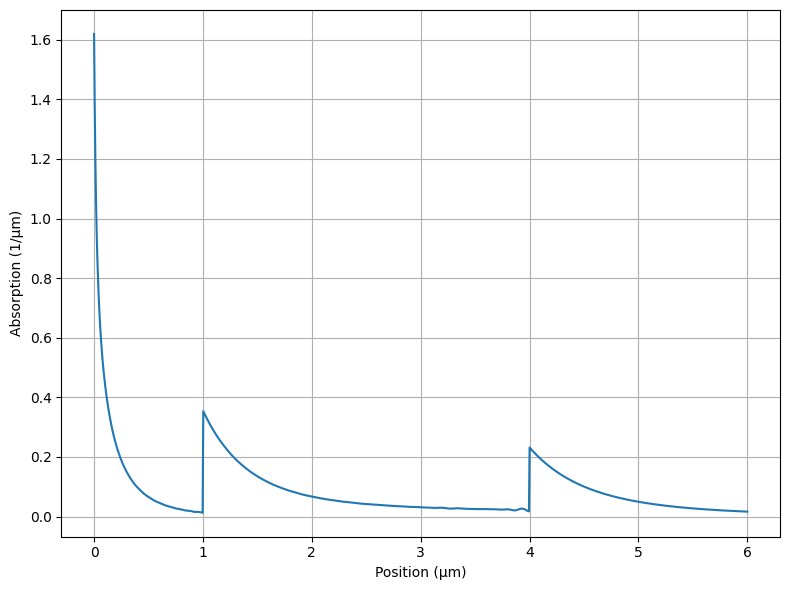

In [5]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

ax.plot(jll_utils_units.convert_m_to_um(position), absorption_location)

ax.set_xlabel("Position (µm)")
ax.set_ylabel("Absorption (1/µm)")
ax.grid()

plt.tight_layout()
plt.show()

We can also plot the absorption or Poynting vector at specific wavelengths, which show that different wavelengths are absorbed in the front layer, second layer, or third layer.

In [6]:
wavelengths = jnp.array([400, 700, 1000]) * jll_utils_units.get_nano()
frequencies = jll_utils_spectra.convert_wavelengths_to_frequencies(wavelengths)
inc_angle = 0

n_k = jll_utils_materials.get_n_k(materials, frequencies)

R_TE, T_TE, R_TM, T_TM, results_coeffs = jll.stackrt(
    n_k, thicknesses, frequencies, inc_angle, return_coeffs=True
)

position = onp.linspace(0, sum(thicknesses) * 1.5, 1000)
layer, position_in_layer = jll_utils_position.calc_position_in_structure(
    thicknesses, position
)

results_coeffs = jll_utils_position.calc_position_data(
    layer, position_in_layer, results_coeffs
)

/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(
/bgfs/pleu/juk139/workspace/JaxLayerLumos/jaxlayerlumos/utils_materials.py:118: UserWarning: Extrapolation detected: Some frequencies are outside the given data range.
  warnings.warn(


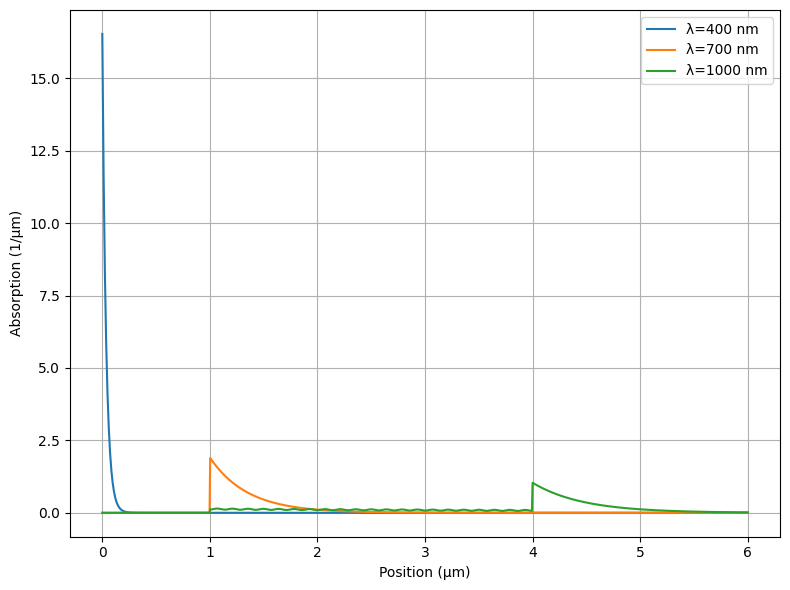

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

absorb_TE_data = results_coeffs['absorb_TE'][0, :, :].T * jll_utils_units.get_micro()

for i, wavelength in enumerate(wavelengths):
    ax.plot(
        jll_utils_units.convert_m_to_um(position),
        absorb_TE_data[:, i],
        label=f'λ={wavelength / jll_utils_units.get_nano():.0f} nm'
    )

ax.set_xlabel("Position (µm)")
ax.set_ylabel("Absorption (1/µm)")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()

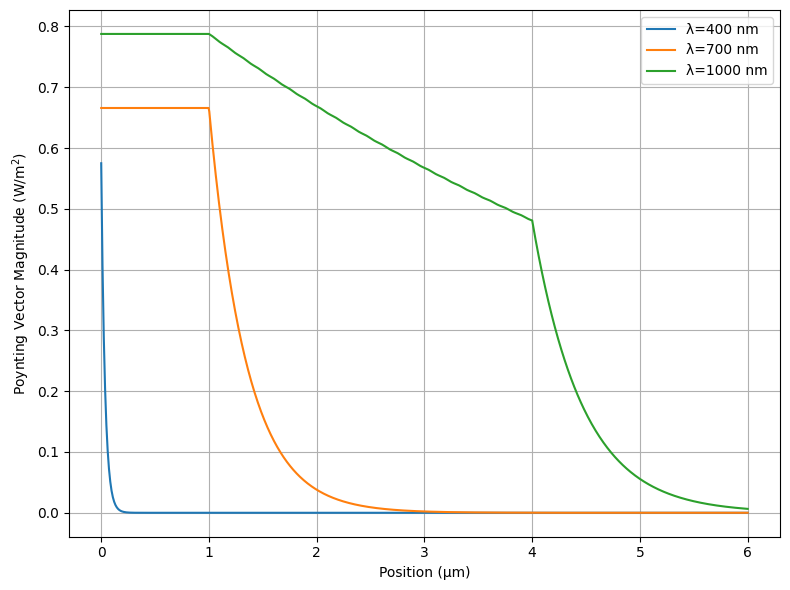

In [8]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca()

poynting = results_coeffs['poyn_TE'][0, :, :].T

for i, wavelength in enumerate(wavelengths):
    ax.plot(
        jll_utils_units.convert_m_to_um(position),
        poynting[:, i],
        label=f'λ={wavelength / jll_utils_units.get_nano():.0f} nm'
    )

ax.set_xlabel("Position (µm)")
ax.set_ylabel("Poynting Vector Magnitude (W/m$^2$)")
ax.grid()

plt.legend()
plt.tight_layout()
plt.show()